# Dive Prediction - Results

*Predicting Seabird Diving Behaviour from GPS data*

This notebook presents results of different algorithms for dive prediction based on a dataset of **74 foraging trips of seabirds** (*Sula Variegata*) with both GPS and Time Depth Recorder (TDR) tracking data. Data has been collected on **Ilha Pescadores, Peru** between 2009 and 2013.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# roc results

In [2]:
unet_mp = pd.read_csv('./results/mp_unet_prediction_5s.csv')
unet_all = pd.read_csv('./results/all_unet_prediction_5s.csv')


hmm = pd.read_csv('./results/hmm_prediction_5s.csv')
ftp = pd.read_csv('./results/ftp_prediction_5s.csv')

In [3]:
def roc(data):
    # globally
    TP = []
    FP = []

    for tt in data.prediction.sort_values().unique():
        all_estim = 1* (data.prediction > tt)
        true_positive = np.mean(all_estim[data.dive == 1])
        true_negative = 1-np.mean(all_estim[data.dive == 0])
        TP.append(true_positive)
        FP.append(1-true_negative)
        
    return (np.array(FP), np.array(TP))

In [4]:
def outsampling(data, resolution):

    data_output = pd.DataFrame()
    for i in data.trip.unique():
        t = data[data.trip == i].copy()

        idx = [i%resolution == 0 for i in range(len(t))]

        traj = t.loc[idx, ('trip', 'datetime', 'lon', 'lat')]

        traj['dive'] = [np.max(t.dive[i:i+resolution]) for i in range(len(t)) if i%resolution==0]
        traj['prediction'] = [np.max(t.prediction[i:i+resolution]) for i in range(len(t)) if i%resolution==0]

        data_output = data_output.append(traj, ignore_index=True)

    return data_output

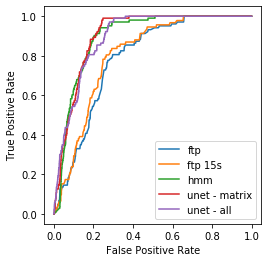

In [6]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# FTP
d = roc(ftp)
plt.plot(d[0], d[1], label = 'ftp')

ftp_ = outsampling(ftp, 3)
d = roc(ftp_)
plt.plot(d[0], d[1], label = 'ftp 15s')


# HMM
d = roc(hmm)
plt.plot(d[0], d[1], label = 'hmm')

# UNET - matrix
d = roc(unet_mp)
plt.plot(d[0], d[1], label = 'unet - matrix')

# UNET -all
d = roc(unet_all)
plt.plot(d[0], d[1], label = 'unet - all')

    
plt.legend()